In [26]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from glob import glob
from datetime import datetime, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
from scipy.special import inv_boxcox, logit
from scipy.special import expit as sigmoid
from scipy.special import softmax

from data.data_path import data_path

In [28]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [29]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# Load data
step_events = load_data(user)
print("n_days raw", len(step_events))
step_events = [i for i in step_events if len(i)]
n_days = len(step_events)
print("n_days after filtering empty days", len(step_events))

n_days raw 18
n_days after filtering empty days 17


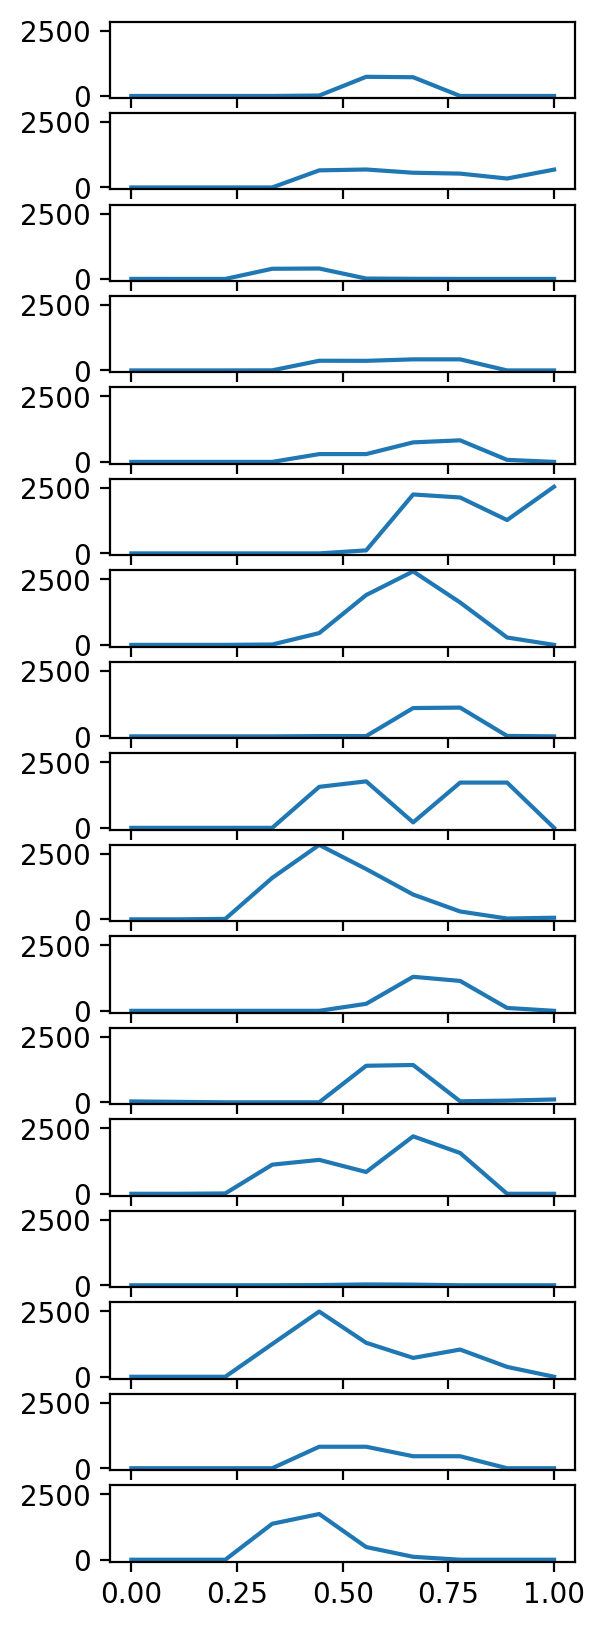

In [30]:
n_timestep = 10
timestep = np.linspace(0, 1, n_timestep)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / (timestep.size-1)
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    # print(np.sum(deriv_cum_steps_day))
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))


fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [31]:
class StepTransformer:
    def __init__(self):
        self.step_scaler = MinMaxScaler(feature_range=(1, 10))
        self.lambda_param = None

    def fit_transform(self, step_events):
        all_steps = np.concatenate(step_events)
        all_steps = logit(all_steps)
        all_steps = self.step_scaler.fit_transform(all_steps.reshape(-1, 1)).flatten()
        all_steps, self.lambda_param = stats.boxcox(all_steps)
        return self.transform(step_events)
    
    def _transform(self, step_events):
        X = np.asarray(step_events).reshape(-1, 1)
        return stats.boxcox(self.step_scaler.transform(logit(X)).flatten(), lmbda=self.lambda_param)
        
    def _inv_transform(self, transformed):
        return sigmoid(self.step_scaler.inverse_transform(inv_boxcox(transformed, self.lambda_param).reshape(-1, 1)).flatten())
    
    def transform(self, step_events):
        if isinstance(step_events, list):
            transformed = []
            for day in range(len(step_events)):
                transformed.append(self._transform(step_events[day]))
        else:
            transformed = self._transform(step_events)
        return transformed

    def inverse_transform(self, transformed):
        if not hasattr(self, "lambda_param"):
            raise ValueError("The transformer has not been fitted yet")
        if isinstance(transformed, list):
            inversed = []
            for day in range(len(transformed)):
                inversed.append(self._inv_transform(transformed[day]))
        else:
            inversed = self._inv_transform(transformed)
        return inversed

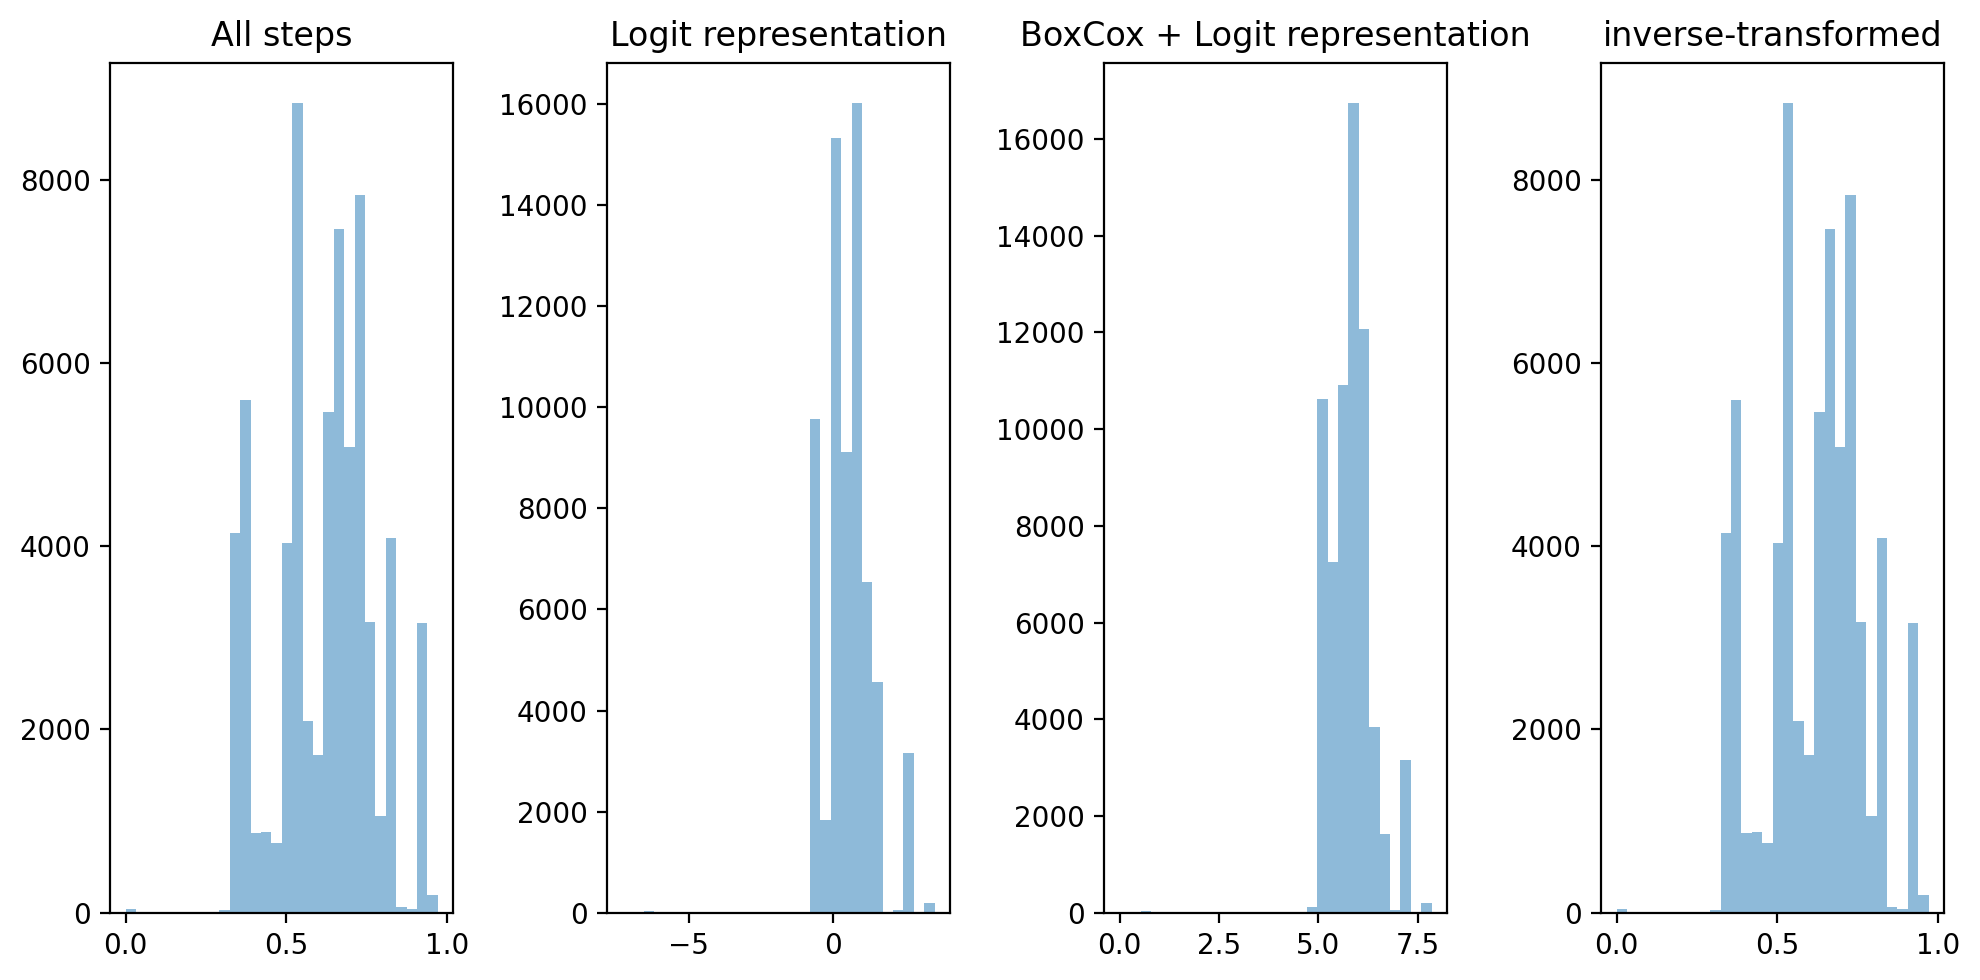

In [32]:
step_transformer = StepTransformer()
transformed_all_steps = step_transformer.fit_transform(step_events)
untransformed_all_steps = step_transformer.inverse_transform(transformed_all_steps)

fig, axes = plt.subplots(ncols=4, figsize=(10, 5))
fig.set_tight_layout(True)

ax = axes[0]
ax.set_title(f"All steps")
ax.hist(np.concatenate(step_events), bins=30, color="C0", alpha=0.5)

ax = axes[1]
ax.set_title("Logit representation")
ax.hist(logit(np.concatenate(step_events)), bins=30, color="C0", alpha=0.5)

ax = axes[2]
ax.set_title("BoxCox + Logit representation")
ax.hist(np.concatenate(transformed_all_steps), bins=30, color="C0", alpha=0.5)

ax = axes[3]
ax.set_title("inverse-transformed")
ax.hist(np.concatenate(untransformed_all_steps), bins=30, color="C0", alpha=0.5);

# Fit model gamma (lowest in hierachy)

In [33]:
class ParamTransformer:
    def __init__(self, step_events):
        self.max_n = max([len(step_events[day]) for day in range(n_days)])
    
    def transform(self, gmm):
        
        # This will be useful to fit the 2nd level GMM ---------------- 
        transformed_means = gmm.means_.flatten()
        transformed_vars = np.log1p(gmm.covariances_).flatten()
        transformed_weights = logit(gmm.weights_).flatten()
        transformed_n = np.atleast_1d(np.log(X.size / self.max_n))
        
        if n_components == 1:
            features = [transformed_means, transformed_vars, transformed_n]

        else:
            features = [transformed_means, transformed_vars, transformed_weights, transformed_n]
        return np.concatenate(features)
        
    def inverse_transform(self, features, n_components):
        transformed_means = features[:n_components]
        transformed_vars = features[n_components:2*n_components]
        if n_components == 1:
            transformed_weights = np.empty(0)
        else:
            transformed_weights = features[2*n_components:-1]
        transformed_n = features[-1]
            
        means = sigmoid(transformed_means)
        variances = np.expm1(transformed_vars)
        if n_components == 1:
            weights = np.ones(1)
        else:
            weights = softmax(transformed_weights)  # We want it to sum to 1
        
        n = int(np.exp(transformed_n) * self.max_n)
        
        return {"means": means, "variances": variances, "weights": weights, "n": n}

In [34]:
# Define the range of number of components to try
n_model_types = 20
n_components_range = range(1, 1+n_model_types)

# Array to hold the BIC for each number of components
cmp_score = np.zeros((n_days, len(list(n_components_range))))

# Prepare the containers for the 2nd level GMM (GMM Beta) -------
all_features = []  
for n_components in n_components_range:
    if n_components == 1:
        # for each model: per day, logit(mean), log1p(var), n
        all_features.append(np.zeros((n_days, 3)))
    else:
        # for each model: per day, logit(means), log1p(var), logit(coeff)
        all_features.append(np.zeros((n_days, n_components*3+1)))

param_transformer = ParamTransformer(step_events)

# For evaluation purposes, we will also store generated steps
gen_deriv_cum_steps = np.zeros((len(list(n_components_range)), n_days, n_timestep))

# ------------------------------------------------------------------

for day in tqdm(range(n_days)):
    # print(f"Day {day}", len(step_events[day]), "steps")
    X = transformed_all_steps[day].reshape(-1, 1)
    
    # Fit a Gaussian Mixture Model for each number of components
    for model, n_components in enumerate(n_components_range):
        gmm = GaussianMixture(n_components=n_components, random_state=123)
        gmm.fit(X)
        cmp_score[day, model] = gmm.bic(X)
    
        features = param_transformer.transform(gmm)
        all_features[model][day] = features
        # param_transformer.inverse_transform(features, n_components)
        
        
        n = len(X.flatten())
        samples_gamma, _ = gmm.sample(n_samples=n) 
        
        step_events_day = step_transformer.inverse_transform(samples_gamma)
        # print(step_events_day.shape)
        
        # print(f"Day {day} is generated with {n_comp} components (model {model}), and contains {n} steps")
        
        step_events_day = np.sort(step_events_day.flatten())
        cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
        deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
        gen_deriv_cum_steps[model, day] = deriv_cum_steps_day

  0%|          | 0/17 [00:00<?, ?it/s]

Text(0.02, 0.5, 'Days')

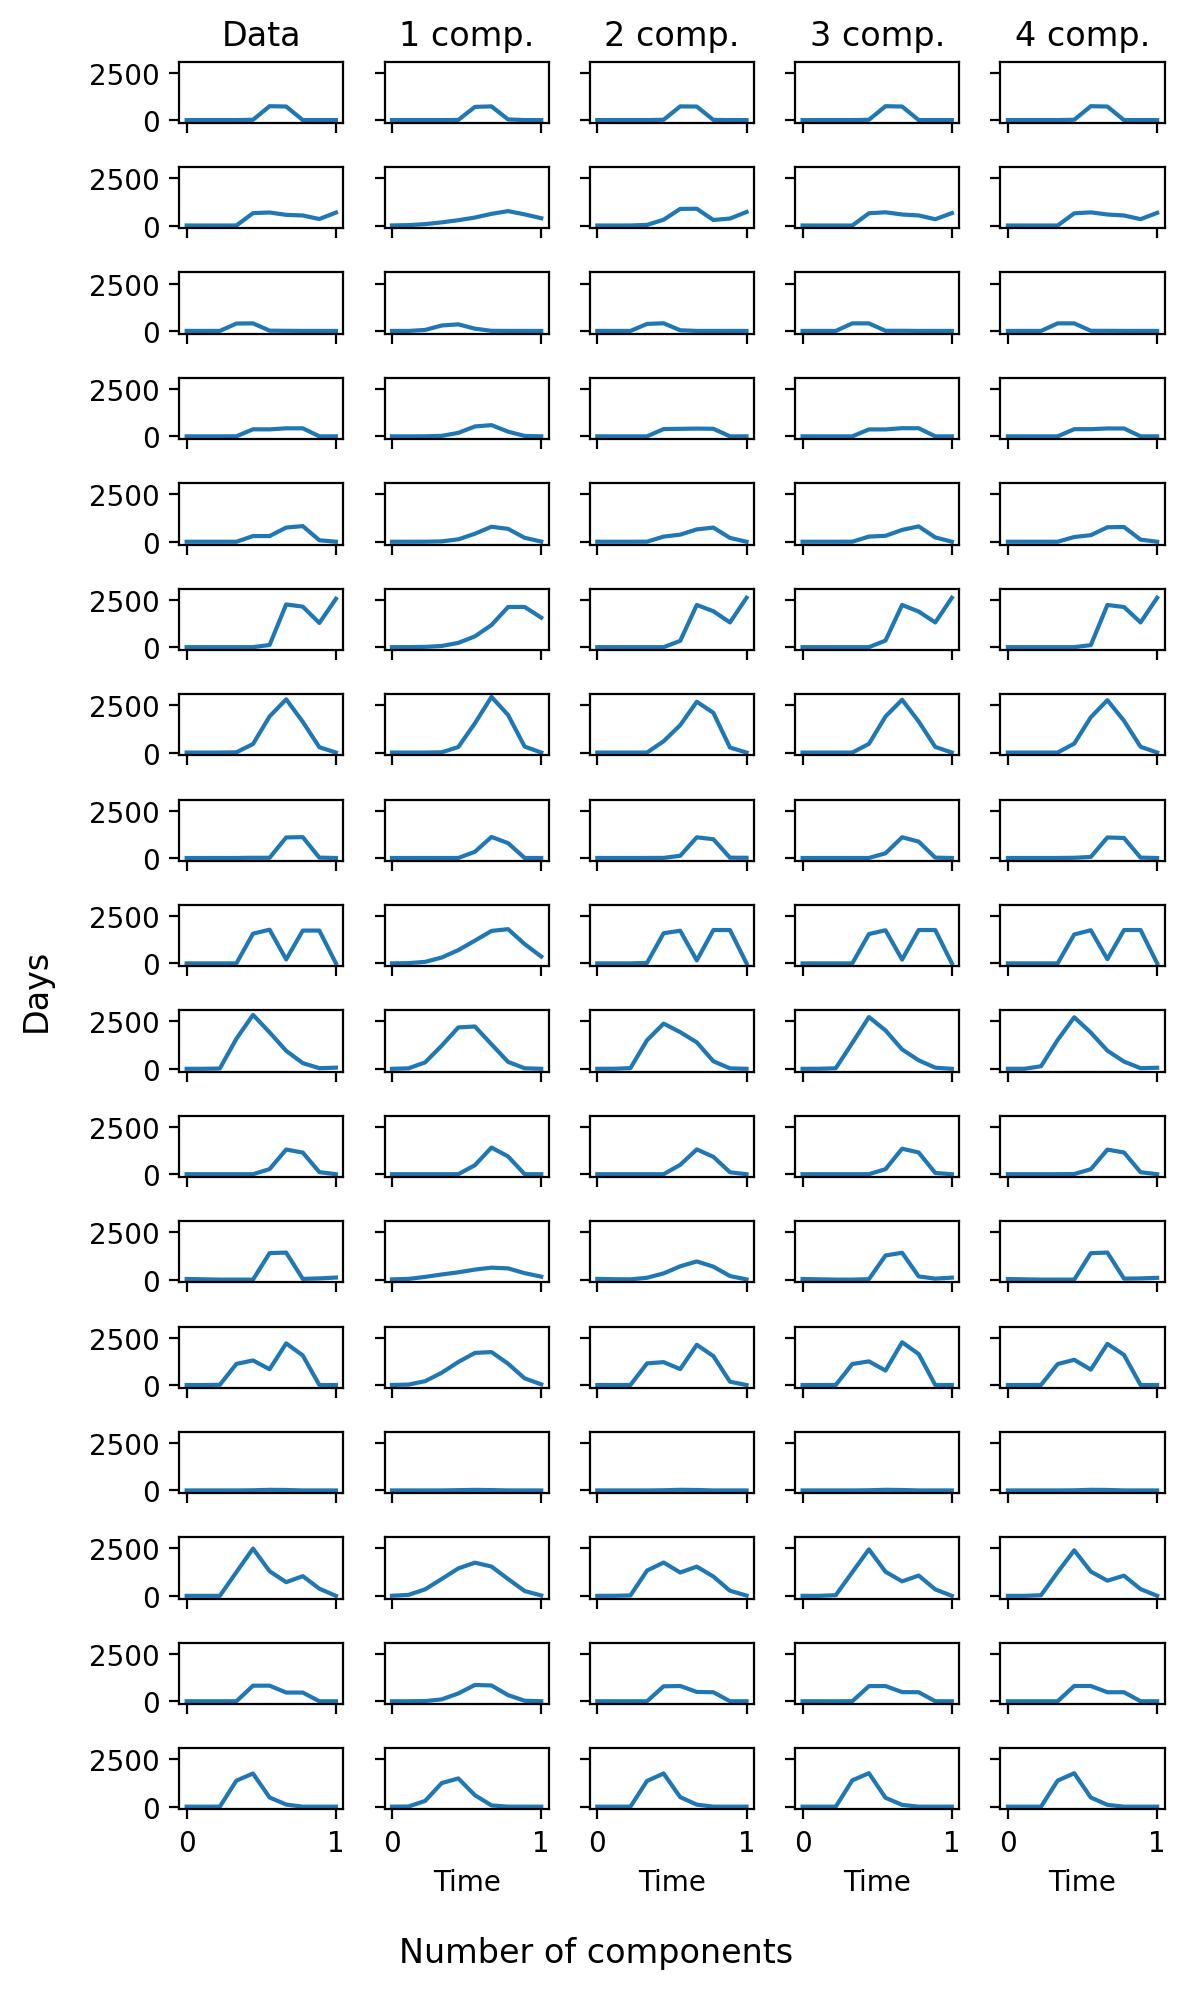

In [47]:
n_model_plot = min(len(list(n_components_range)), 4)

fig, axes = plt.subplots(
    ncols=n_model_plot+1, 
    nrows=n_days,
    figsize=(6, 10), sharex=True, sharey=True)

fig.set_tight_layout(True)

for day in range(n_days):
    ax = axes[day, 0]
    ax.plot(timestep, deriv_cum_steps[day], color="C0")
    if day == 0:
        ax.set_title("Data")
    for model in range(n_model_plot):
        ax = axes[day, model+1]
        ax.plot(timestep, gen_deriv_cum_steps[model, day], color="C0")
        ax.grid(False)
        if day == 0:
            ax.set_title(f"{n_components_range[model]} comp.")
        elif day == n_days-1:
            ax.set_xlabel("Time")

fig.supxlabel("Number of components")
fig.supylabel("Days")

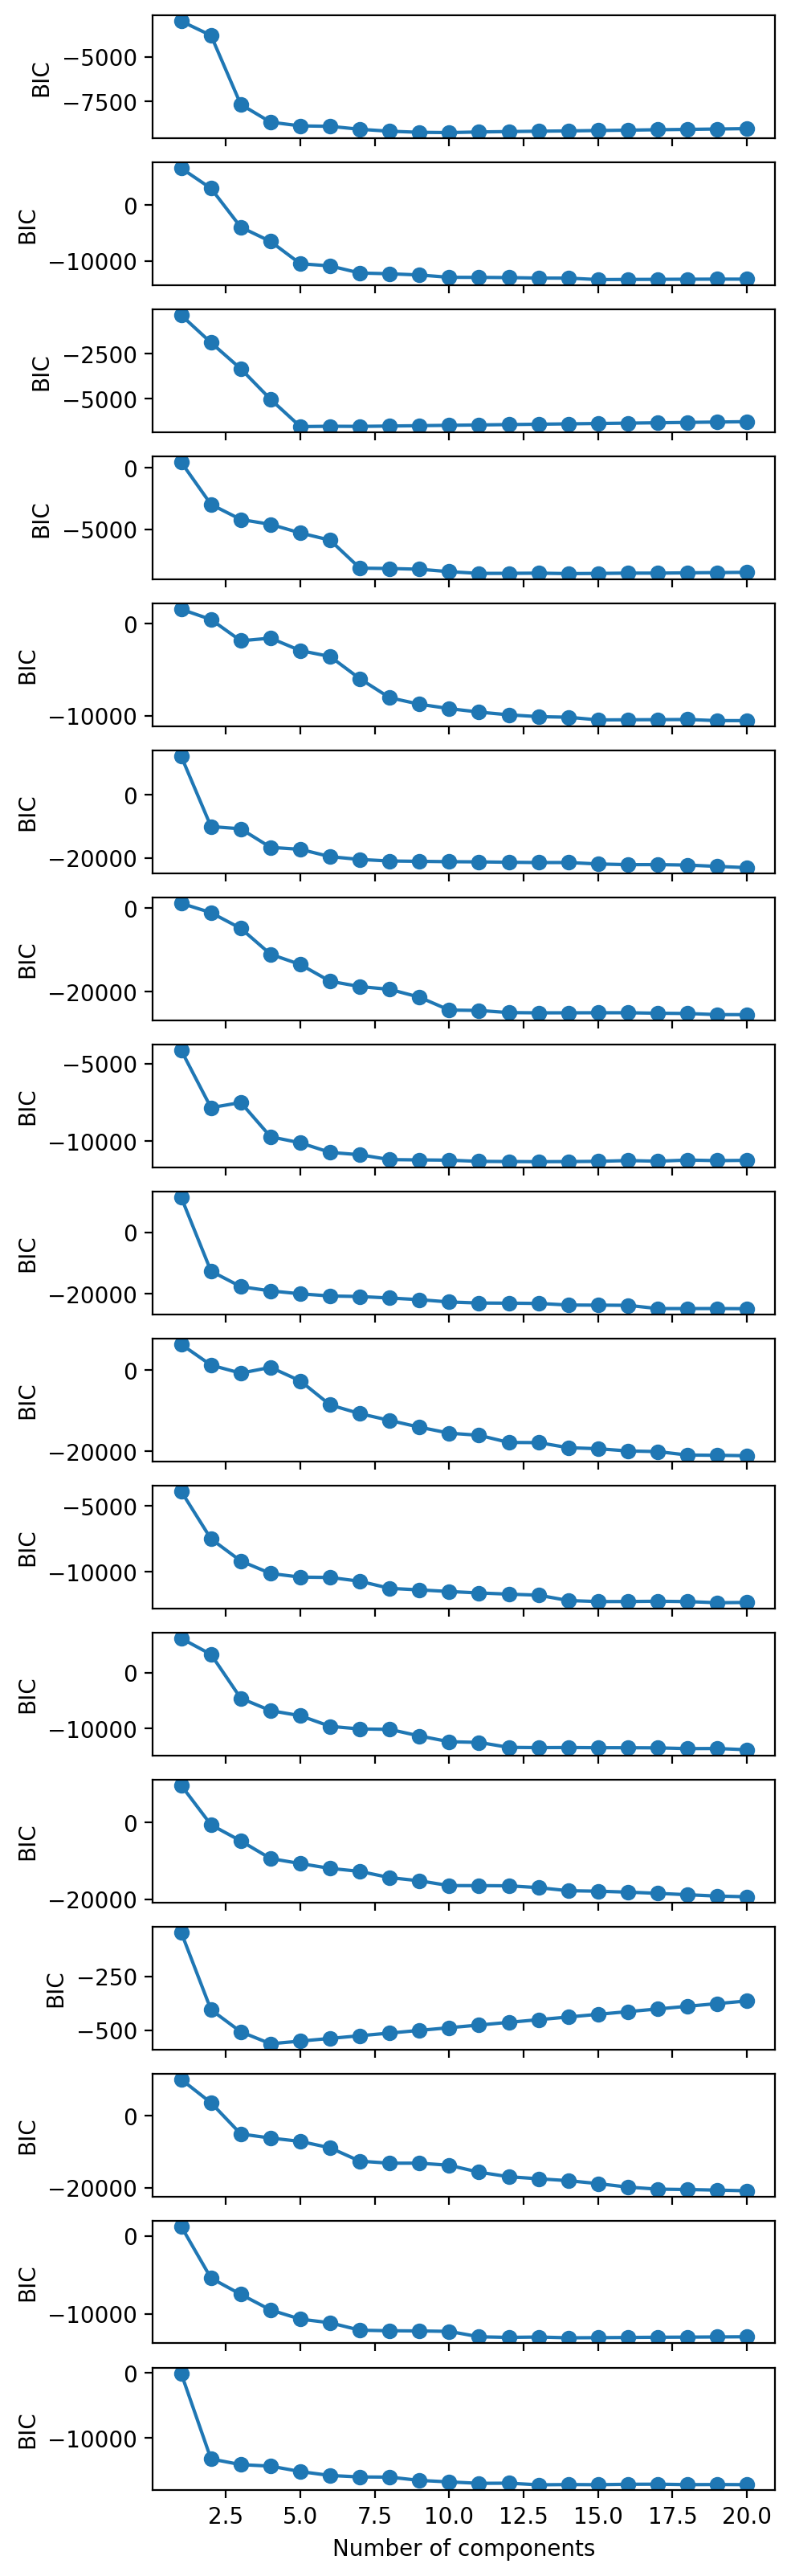

In [49]:
fig, axes = plt.subplots(nrows=n_days, figsize=(5, 20), sharex=True)
for day in range(n_days):
    ax = axes[day]
    ax.plot(n_components_range, cmp_score[day], marker='o')
    if day == n_days-1:(
        ax.set_xlabel('Number of components'))
    ax.set_ylabel('BIC')

# Fit model beta (second in hierarchy)

In [106]:
# Fit the beta-model (intermediary level with only one component atm) that will be used to draw the parameters of the gamma-model (lowest in hierarchy) given a specific number of components (the specific number of components will be drawn using the alpha-model)
all_beta_gmm = [GaussianMixture(n_components=1).fit(params[model]) for model in range(n_model_types)]

# Fit model alpha (top in hierarchy)

In [107]:
class ScoreTransformer:
    def __init__(self):
        self.score_scaler = MinMaxScaler(feature_range=(1, 10))
        self.lambda_param = None
    def fit_transform(self, scores):
        org_shape = scores.shape
        scaled_scores = self.score_scaler.fit_transform(scores.flatten().reshape(-1, 1)).flatten()
        transformed_scores, self.lambda_param = stats.boxcox(scaled_scores)
        return transformed_scores.reshape(org_shape)
    def transform(self, scores):
        org_shape = scores.shape
        scaled_scores = self.score_scaler.transform(scores.flatten().reshape(-1, 1)).flatten()
        transformed_scores = stats.boxcox(scaled_scores, lmbda=self.lambda_param)
        return transformed_scores.reshape(org_shape)
    def inverse_transform(self, transformed_scores):
        org_shape = transformed_scores.shape
        untransformed_scores_ = inv_boxcox(transformed_scores.flatten().reshape(-1, 1), self.lambda_param)
        untransformed_scores = self.score_scaler.inverse_transform(untransformed_scores_).reshape(org_shape)
        return untransformed_scores

In [108]:
# Transform the scores
score_transformer = ScoreTransformer()
transformed_scores = score_transformer.fit_transform(cmp_score)
untransformed_scores = score_transformer.inverse_transform(transformed_scores)

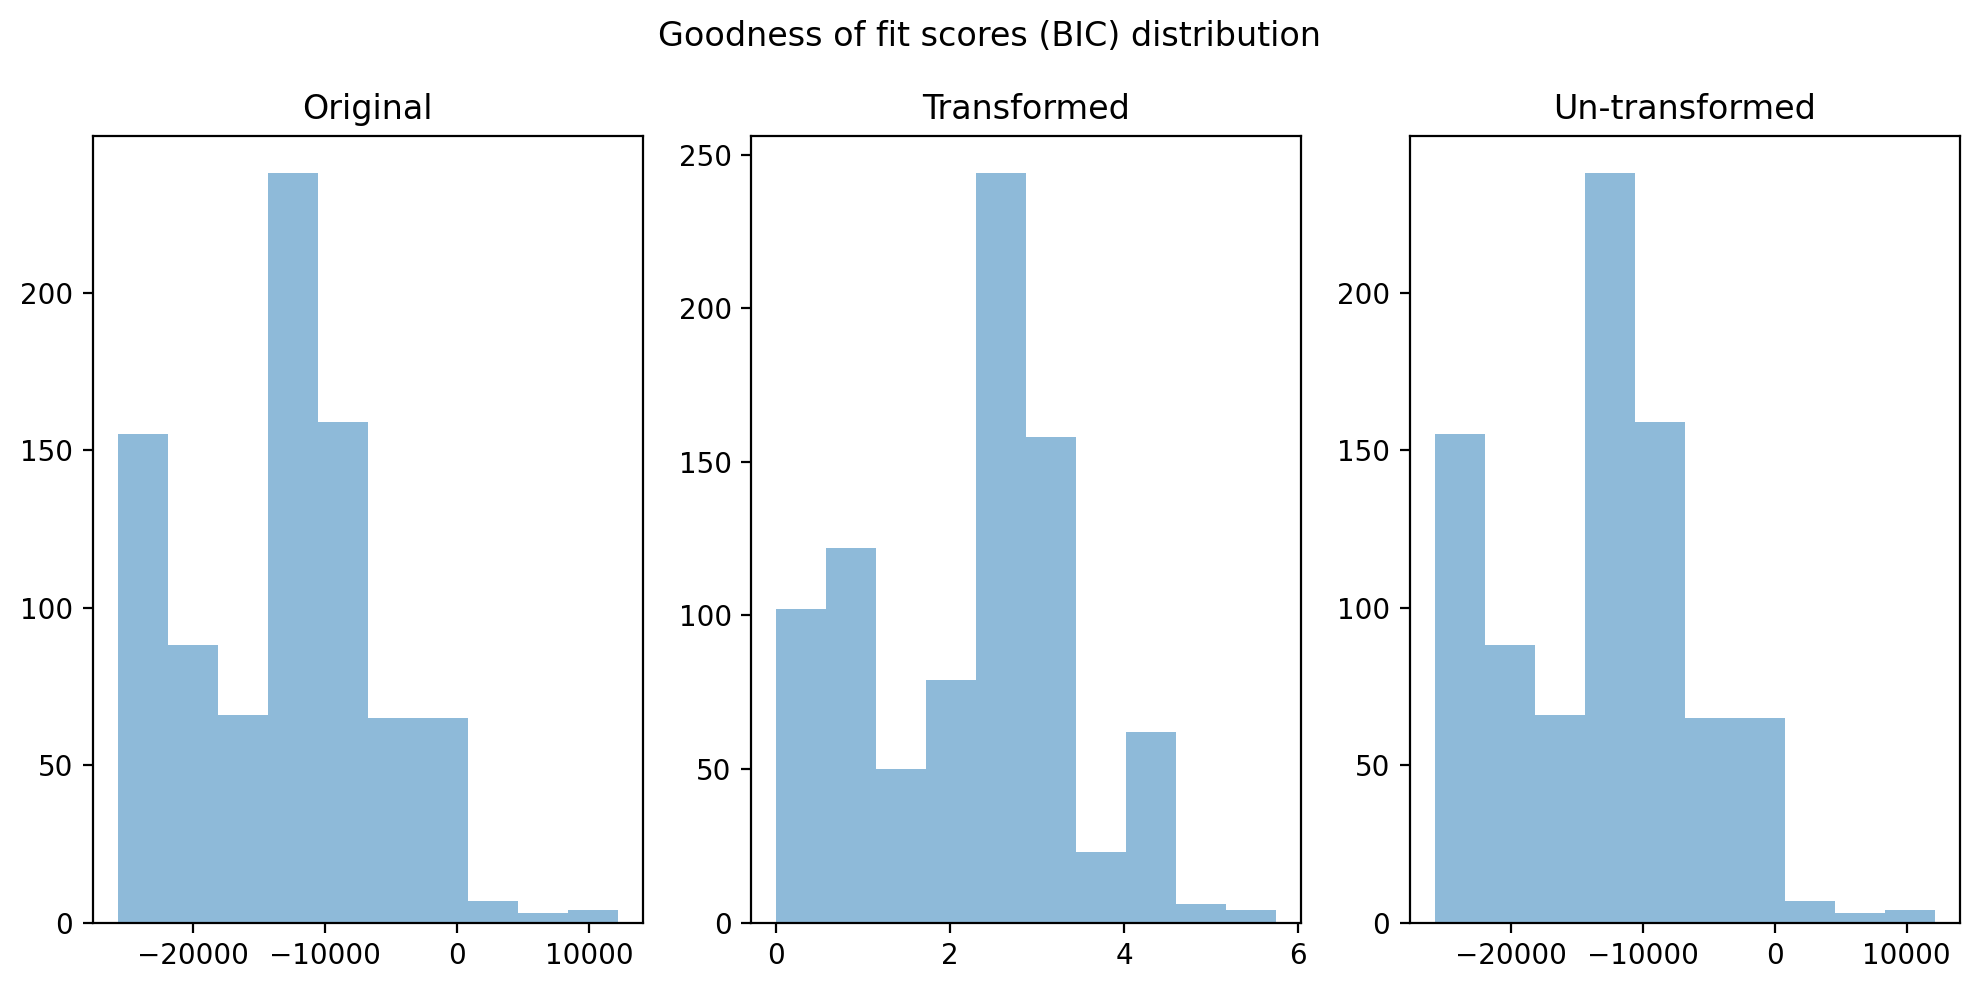

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
fig.set_tight_layout(True)
fig.suptitle("Goodness of fit scores (BIC) distribution")

ax = axes[0]
ax.set_title("Original")
ax.hist(cmp_score.flatten(), color="C0", alpha=0.5)

ax = axes[1]
ax.set_title("Transformed")
ax.hist(transformed_scores.flatten(), color="C0", alpha=0.5)

ax = axes[2]
ax.set_title("Un-transformed")
ax.hist(untransformed_scores.flatten(), color="C0", alpha=0.5);

In [110]:
n_components_range_alpha = range(1, 4)

# 3. Fit a 3rd level GMM with the bic scores
all_alpha_gmm = [GaussianMixture(n_components=n_components, random_state=34).fit(transformed_scores) for n_components in n_components_range_alpha]
all_alpha_scores = [gmm.bic(transformed_scores) for gmm in all_alpha_gmm]

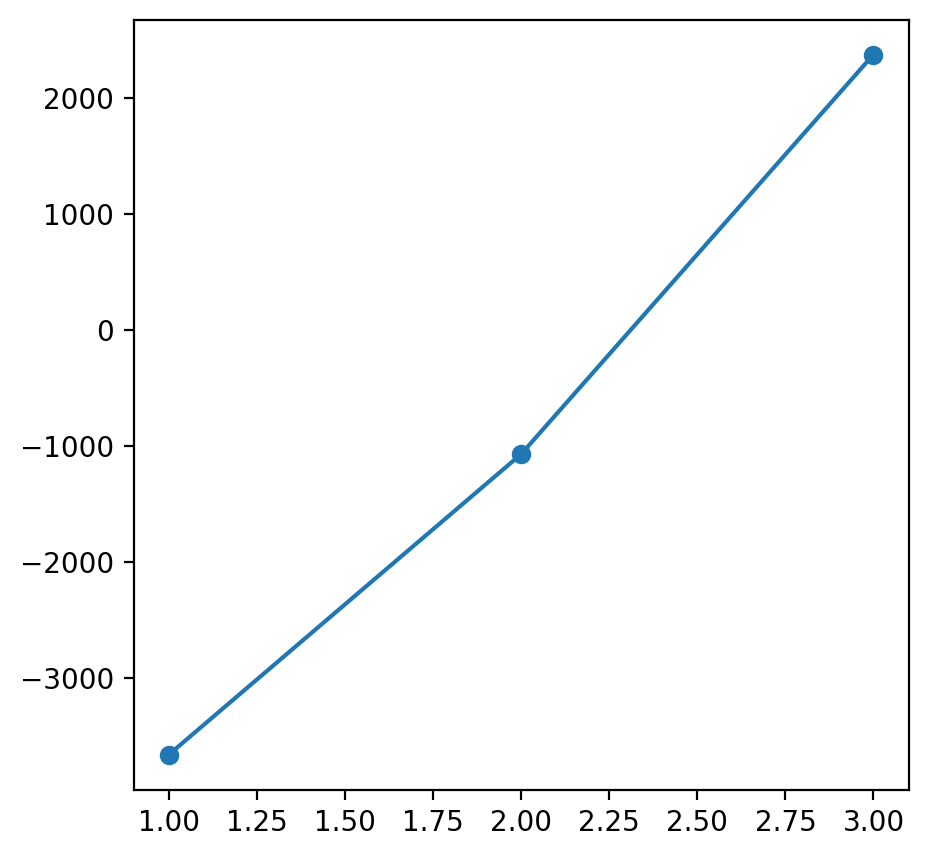

In [111]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_components_range_alpha, all_alpha_scores, marker='o')

In [112]:
# 4. Choose the best model
best_alpha_idx = np.argmin(all_alpha_scores)
best_alpha_gmm = all_alpha_gmm[best_alpha_idx]

# Sample from the best alpha model

In [113]:
# How many days to sample
n_sample_alpha = 10

samples_alpha, _ = best_alpha_gmm.sample(n_samples=n_sample_alpha)

untransformed_scores = score_transformer.inverse_transform(samples_alpha)

In [114]:
np.sum(np.isnan(untransformed_scores))

0

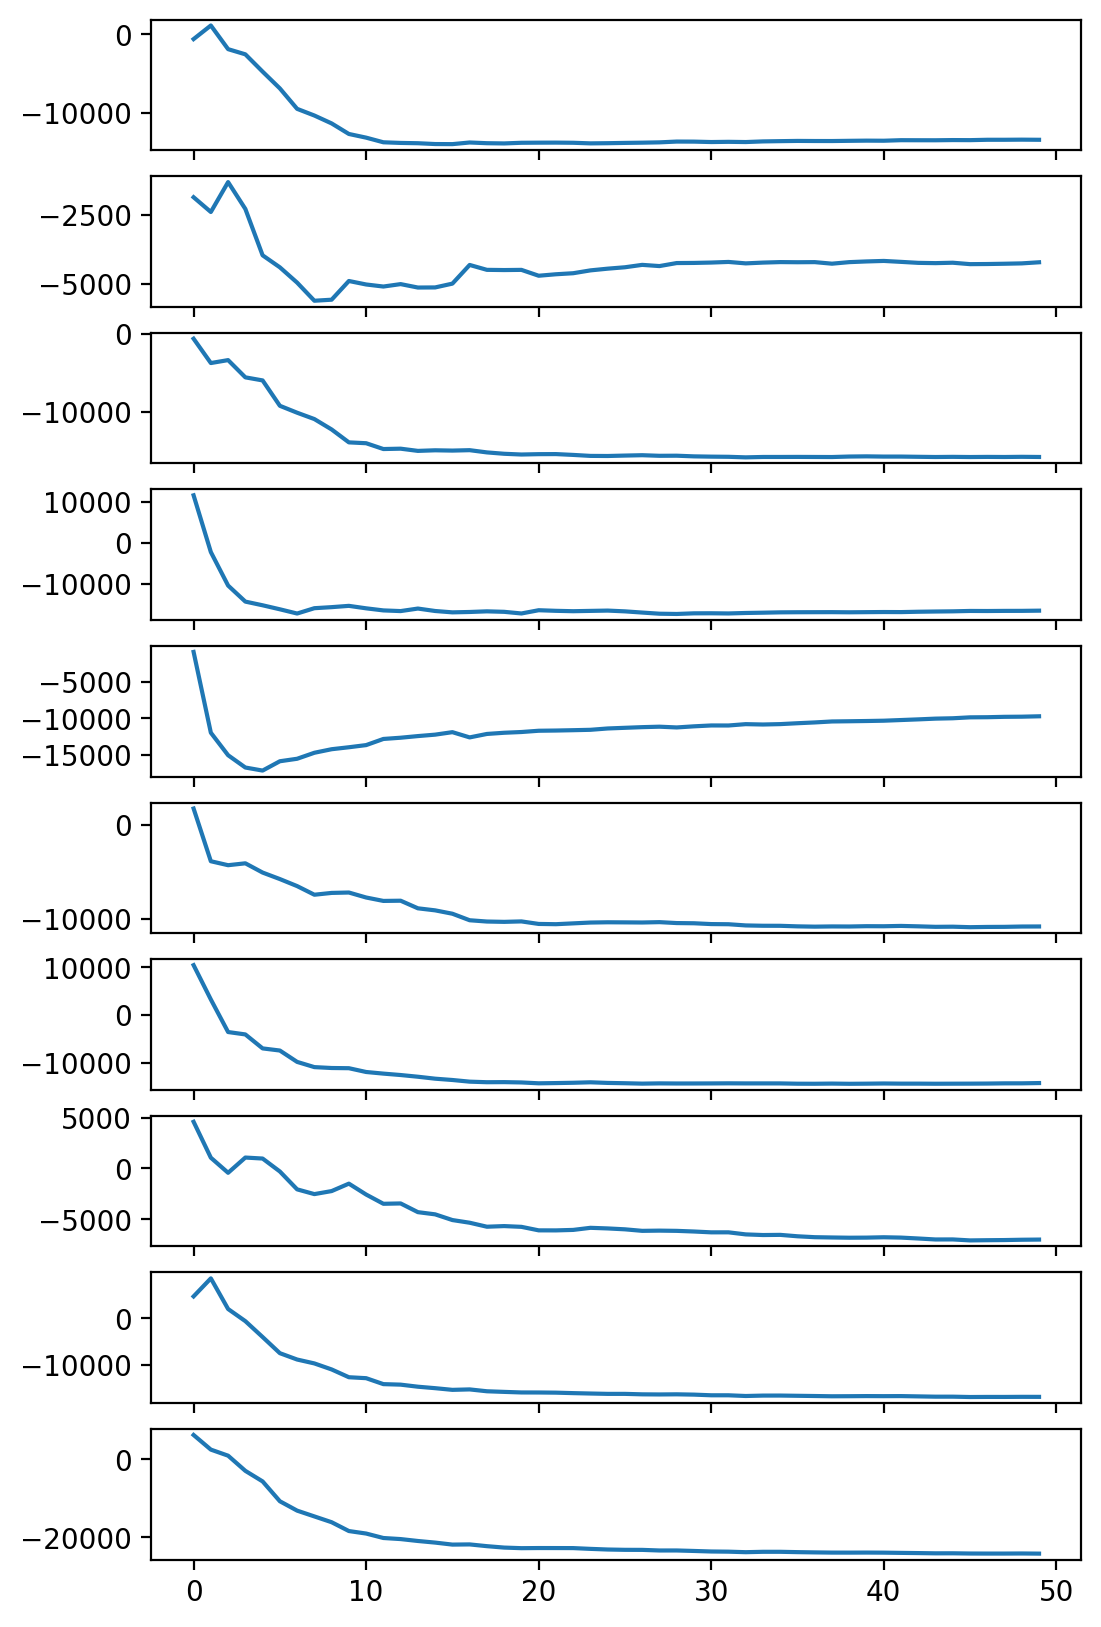

In [115]:
n_sample_plot = min(n_sample_alpha, 10)
fig, axes = plt.subplots(figsize=(6, 10), sharex=True, nrows=n_sample_plot)
for day in range(n_sample_plot):
    ax = axes[day]
    ax.plot(untransformed_scores[day])

In [118]:
np.random.seed(1234)

deriv_cum_steps = np.zeros((n_sample_alpha, n_timestep))

for day in range(n_sample_alpha):
    
    # Choose with type of model to use ---------------------------
    
    # Using the alpha-model, draw a model type for model-gamma according to the goodness of fit scores
    smp_alpha = samples_alpha[day]
    norm_score = (smp_alpha-smp_alpha.mean())/smp_alpha.std()
    p_according_to_gof = softmax(norm_score)
    
    model_idx = np.random.choice(n_model_types, p=p_according_to_gof)
    n_comp = list(n_components_range)[model_idx]

    # Using the beta-model (intermediary level), draw the parameters of the gamma-model (lowest in hierarchy) given the number of components that has just be drawn using the alpha-model)

    beta_gmm = all_beta_gmm[model_idx]
    # Set the random state to the day to have different (but reproducible) results
    beta_gmm.random_state = day

    # The samples represent the parameters of the gamma-model (means, variances, weights and number of steps)
    samples_beta, _ = beta_gmm.sample(n_samples=1)
    
    smp_beta = samples_beta[0]
    params = param_transformer.inverse_transform(smp_beta, n_comp)
    
    # Set up the gamma-model
    gmm = GaussianMixture(n_components=n_comp)
    gmm.means_ = params["means"].reshape(-1, 1)
    gmm.covariances_ = params["variances"].reshape(-1, 1, 1)
    gmm.weights_ = params["weights"]
    
    # Get the number of samples to draw (= number of steps)
    n = params["n"]
    
    print("n", n)
    samples_gamma, _ = gmm.sample(n_samples=n) 
    
    print(f"Day {day} is generated with {n_comp} components (model {model_idx}), and contains {n} steps")
    
    step_events_day = np.sort(samples_gamma.flatten())
    cum_steps_day = np.sum(step_events_day <= timestep[:, None], axis=1)
    deriv_cum_steps_day = np.gradient(cum_steps_day, timestep + 1) / (timestep.size - 1)
    deriv_cum_steps[day] = deriv_cum_steps_day 

n 4738
Day 0 is generated with 2 components (model 1), and contains 4738 steps
n 3696
Day 1 is generated with 3 components (model 2), and contains 3696 steps
n 4355
Day 2 is generated with 1 components (model 0), and contains 4355 steps
n 11169
Day 3 is generated with 47 components (model 46), and contains 11169 steps
n 1964
Day 4 is generated with 43 components (model 42), and contains 1964 steps
n 1600
Day 5 is generated with 1 components (model 0), and contains 1600 steps
n 3902
Day 6 is generated with 1 components (model 0), and contains 3902 steps
n 2041
Day 7 is generated with 22 components (model 21), and contains 2041 steps
n 3175
Day 8 is generated with 32 components (model 31), and contains 3175 steps
n 627
Day 9 is generated with 22 components (model 21), and contains 627 steps


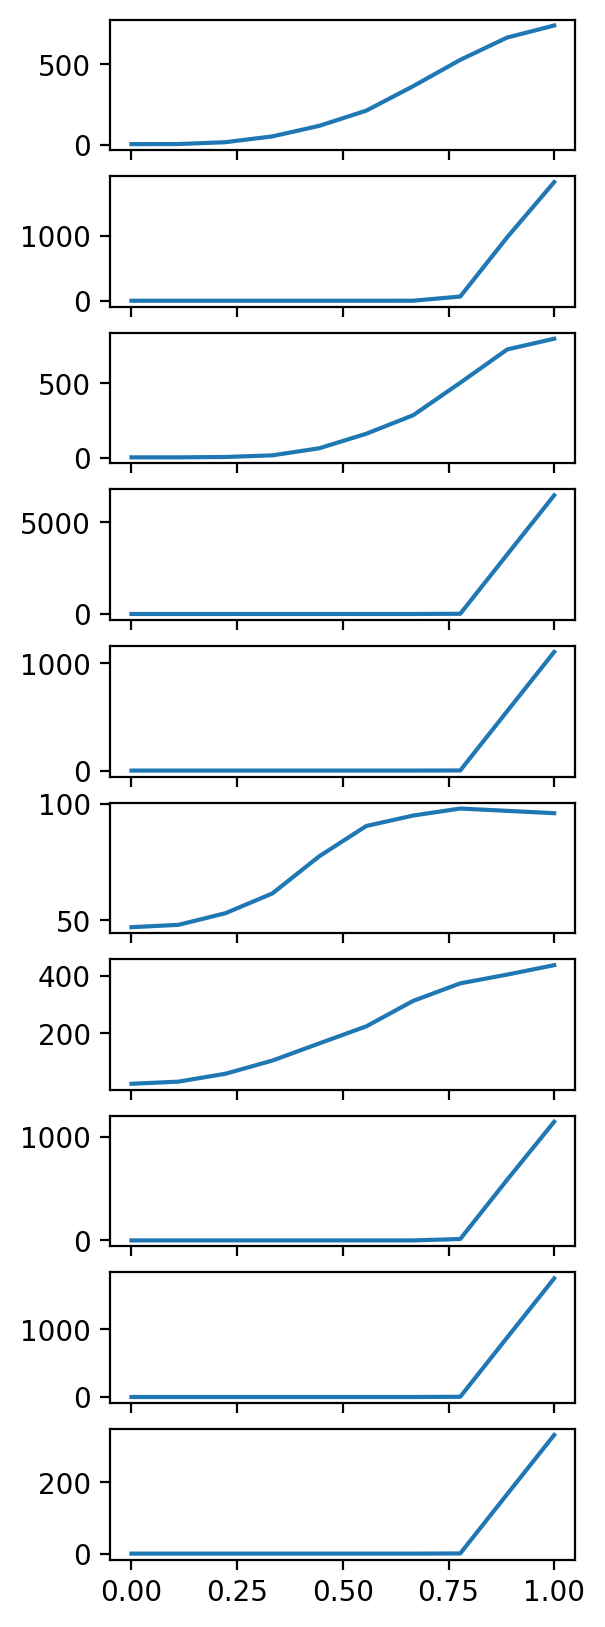

In [120]:
fig, axes = plt.subplots(min(deriv_cum_steps.shape[0], 10), figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    # ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)